<a href="https://colab.research.google.com/github/janithcyapa/SmartHVAC/blob/main/Cooling_and_heating_paths_of_psychrometric_chart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#psychrolib library instal
!pip install psychrolib==2.4.0

  Preparing metadata (setup.py) ... done
  Created wheel for psychrolib: filename=PsychroLib-2.4.0-py3-none-any.whl size=9220 sha256=afc51b44f58a2805e7c62aaaa4b77c8575fbe7462200acbb201c62c08d1b7570
  Stored in directory: /root/.cache/pip/wheels/a7/4b/9a/f41e061924c94743813d4ba15ab5a773a9663e34d87d2f2c93
Successfully built psychrolib


  The cooling process is currently running. Errors in the heating process need to be resolved.

Enter process type: 'cooling' (cooling with dehumidification) or 'heating' (sensible heating)
Process type: cooling
Enter initial dry bulb temperature (°C): 31
Enter initial relative humidity (%): 87
Enter final dry bulb temperature (°C): 18
Enter final relative humidity (%): 45

Initial State:
Dry Bulb Temperature: 31.00 °C
Relative Humidity: 87.00%
Humidity Ratio: 0.024973 kg/kg
Enthalpy: 95.08 kJ/kg
Wet Bulb Temperature: 29.11 °C
Dew Point Temperature: 28.58 °C

Dew Point State:
Dry Bulb Temperature: 28.58 °C
Relative Humidity: 100.00%
Humidity Ratio: 0.024973 kg/kg
Enthalpy: 92.53 kJ/kg
Wet Bulb Temperature: 28.58 °C
Dew Point Temperature: 28.58 °C

Saturated State (at target humidity ratio):
Dry Bulb Temperature: 5.90 °C
Relative Humidity: 100.00%
Humidity Ratio: 0.005755 kg/kg
Enthalpy: 20.39 kJ/kg
Wet Bulb Temperature: 5.90 °C
Dew Point Temperature: 5.90 °C

Final State:
Dry Bulb Temperature: 18.00 °C
Relative Humidity: 45.00%
Humidity Ratio: 0.005755 kg/kg
Enthalpy: 32.69 kJ/kg

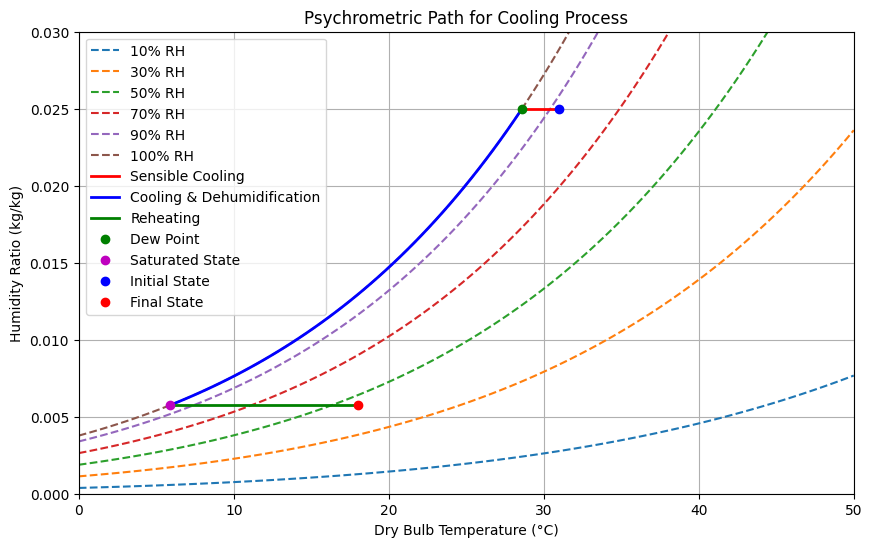

In [3]:
import psychrolib
import numpy as np
import matplotlib.pyplot as plt

# Set unit system to SI
psychrolib.SetUnitSystem(psychrolib.SI)

# Standard atmospheric pressure
P = 101325  # Pa

# Custom function to find dry bulb temperature given humidity ratio and relative humidity
def get_T_dry_bulb_from_hum_ratio_and_rel_hum(W_target, RH, P, T_min=0, T_max=50, tolerance=1e-7):
    """Iteratively find T_db such that GetHumRatioFromRelHum(T_db, RH, P) ≈ W_target."""
    while T_max - T_min > tolerance:
        T_mid = (T_min + T_max) / 2
        W_mid = psychrolib.GetHumRatioFromRelHum(T_mid, RH, P)
        if abs(W_mid - W_target) < tolerance:
            return T_mid
        elif W_mid < W_target:
            T_min = T_mid
        else:
            T_max = T_mid
    return (T_min + T_max) / 2

# Get user input
print("Enter process type: 'cooling' (cooling with dehumidification) or 'heating' (sensible heating)")
process_type = input("Process type: ").lower()
T_db_initial = float(input("Enter initial dry bulb temperature (°C): "))
RH_initial = float(input("Enter initial relative humidity (%): ")) / 100
T_db_final = float(input("Enter final dry bulb temperature (°C): "))
RH_final = float(input("Enter final relative humidity (%): ")) / 100

# Validate inputs
if T_db_final > T_db_initial and process_type == "cooling":
    print("Error: Final temperature is higher than initial for cooling process.")
    exit()
elif T_db_final < T_db_initial and process_type == "heating":
    print("Error: Final temperature is lower than initial for heating process.")
    exit()

# Calculate psychrometric properties for initial state
W_initial = psychrolib.GetHumRatioFromRelHum(T_db_initial, RH_initial, P)
h_initial = psychrolib.GetMoistAirEnthalpy(T_db_initial, W_initial)
T_wb_initial = psychrolib.GetTWetBulbFromHumRatio(T_db_initial, W_initial, P)
T_dp_initial = psychrolib.GetTDewPointFromHumRatio(T_db_initial, W_initial, P)

# Initialize variables
T_db_dew = T_dp_initial
W_dew = W_initial
h_dew = psychrolib.GetMoistAirEnthalpy(T_db_dew, W_dew)
T_wb_dew = psychrolib.GetTWetBulbFromHumRatio(T_db_dew, W_dew, P)
T_dp_dew = T_db_dew

T_db_sat = W_sat = h_sat = T_wb_sat = T_dp_sat = None
W_final = psychrolib.GetHumRatioFromRelHum(T_db_final, RH_final, P)

# Process-specific calculations
if process_type == "cooling":
    if T_db_final >= T_dp_initial or W_final >= W_initial:
        # Sensible cooling only (no dehumidification needed)
        W_final = W_initial
        T_db_sat = T_db_final
        W_sat = W_initial
        h_sat = psychrolib.GetMoistAirEnthalpy(T_db_sat, W_sat)
        T_wb_sat = psychrolib.GetTWetBulbFromHumRatio(T_db_sat, W_sat, P)
        T_dp_sat = psychrolib.GetTDewPointFromHumRatio(T_db_sat, W_sat, P)
    else:
        # Step 1: Sensible cooling to dew point (done above)
        # Step 2: Cooling along 100% RH curve to target humidity ratio
        T_db_sat = get_T_dry_bulb_from_hum_ratio_and_rel_hum(W_final, 1.0, P)
        W_sat = W_final
        h_sat = psychrolib.GetMoistAirEnthalpy(T_db_sat, W_sat)
        T_wb_sat = psychrolib.GetTWetBulbFromHumRatio(T_db_sat, W_sat, P)
        T_dp_sat = T_db_sat  # At 100% RH, T_db = T_dp
        if T_db_sat > T_db_dew:
            print("Error: Saturated state temperature exceeds dew point.")
            exit()
    # Step 3: Reheating to final state
    h_final = psychrolib.GetMoistAirEnthalpy(T_db_final, W_final)
    T_wb_final = psychrolib.GetTWetBulbFromHumRatio(T_db_final, W_final, P)
    T_dp_final = psychrolib.GetTDewPointFromHumRatio(T_db_final, W_final, P)
else:  # Heating
    W_final = W_initial
    h_final = psychrolib.GetMoistAirEnthalpy(T_db_final, W_final)
    T_wb_final = psychrolib.GetTWetBulbFromHumRatio(T_db_final, W_final, P)
    T_dp_final = psychrolib.GetTDewPointFromHumRatio(T_db_final, W_final, P)

# Print results
print("\nInitial State:")
print(f"Dry Bulb Temperature: {T_db_initial:.2f} °C")
print(f"Relative Humidity: {RH_initial*100:.2f}%")
print(f"Humidity Ratio: {W_initial:.6f} kg/kg")
print(f"Enthalpy: {h_initial/1000:.2f} kJ/kg")
print(f"Wet Bulb Temperature: {T_wb_initial:.2f} °C")
print(f"Dew Point Temperature: {T_dp_initial:.2f} °C")

if process_type == "cooling" and T_db_final < T_dp_initial and W_final < W_initial:
    print("\nDew Point State:")
    print(f"Dry Bulb Temperature: {T_db_dew:.2f} °C")
    print(f"Relative Humidity: 100.00%")
    print(f"Humidity Ratio: {W_dew:.6f} kg/kg")
    print(f"Enthalpy: {h_dew/1000:.2f} kJ/kg")
    print(f"Wet Bulb Temperature: {T_wb_dew:.2f} °C")
    print(f"Dew Point Temperature: {T_dp_dew:.2f} °C")

    print("\nSaturated State (at target humidity ratio):")
    print(f"Dry Bulb Temperature: {T_db_sat:.2f} °C")
    print(f"Relative Humidity: 100.00%")
    print(f"Humidity Ratio: {W_sat:.6f} kg/kg")
    print(f"Enthalpy: {h_sat/1000:.2f} kJ/kg")
    print(f"Wet Bulb Temperature: {T_wb_sat:.2f} °C")
    print(f"Dew Point Temperature: {T_dp_sat:.2f} °C")

print("\nFinal State:")
print(f"Dry Bulb Temperature: {T_db_final:.2f} °C")
print(f"Relative Humidity: {RH_final*100:.2f}%")
print(f"Humidity Ratio: {W_final:.6f} kg/kg")
print(f"Enthalpy: {h_final/1000:.2f} kJ/kg")
print(f"Wet Bulb Temperature: {T_wb_final:.2f} °C")
print(f"Dew Point Temperature: {T_dp_final:.2f} °C")

# Generate psychrometric chart
T_db_range = np.linspace(0, 50, 100)  # Temperature range
RH_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]  # Relative humidity curves
W_values = []

# Calculate humidity ratios for RH curves
for RH in RH_values:
    W = [psychrolib.GetHumRatioFromRelHum(T, RH, P) for T in T_db_range]
    W_values.append(W)

# Plot psychrometric chart
plt.figure(figsize=(10, 6))
for i, RH in enumerate(RH_values):
    plt.plot(T_db_range, W_values[i], label=f"{int(RH*100)}% RH", linestyle='--')

# Plot the process path
if process_type == "cooling" and T_db_final < T_dp_initial and W_final < W_initial:
    # Three-segment path
    # Segment 1: Sensible cooling to dew point
    T_db_path1 = np.linspace(T_db_initial, T_db_dew, 50)
    W_path1 = np.full(50, W_initial)
    # Segment 2: Cooling along 100% RH curve to target humidity ratio
    T_db_path2 = np.linspace(T_db_dew, T_db_sat, 50)
    W_path2 = [psychrolib.GetHumRatioFromRelHum(T, 1.0, P) for T in T_db_path2]
    # Segment 3: Reheating to final state
    T_db_path3 = np.linspace(T_db_sat, T_db_final, 50)
    W_path3 = np.full(50, W_final)
    plt.plot(T_db_path1, W_path1, 'r-', label='Sensible Cooling', linewidth=2)
    plt.plot(T_db_path2, W_path2, 'b-', label='Cooling & Dehumidification', linewidth=2)
    plt.plot(T_db_path3, W_path3, 'g-', label='Reheating', linewidth=2)
    plt.plot(T_db_dew, W_dew, 'go', label='Dew Point')
    plt.plot(T_db_sat, W_sat, 'mo', label='Saturated State')
else:
    # Single-segment path
    T_db_path = np.linspace(T_db_initial, T_db_final, 100)
    W_path = np.full(100, W_initial)
    plt.plot(T_db_path, W_path, 'r-', label='Process Path', linewidth=2)

plt.plot(T_db_initial, W_initial, 'bo', label='Initial State')
plt.plot(T_db_final, W_final, 'ro', label='Final State')

# Customize plot
plt.xlabel('Dry Bulb Temperature (°C)')
plt.ylabel('Humidity Ratio (kg/kg)')
plt.title(f'Psychrometric Path for {process_type.capitalize()} Process')
plt.grid(True)
plt.legend()
plt.xlim(0, 50)
plt.ylim(0, 0.03)
plt.show()